## How we rank days

### Translating UV Index to score
UV Scores are punished when they reach dangerous levels, but not weighted positively so as not to skew days with little sunlight.

$$y= -1\ \left\{x>7\right\} $$

$$y= -\frac{1}{2^{7}}\cdot2^{x}+0.25\ \left\{x\le7\right\} $$

### Translating temperature to score
Temperatures are translated to score in 3 key phases. Extreme negative temperatures are punished, along with positive temperatures that would negatively impact the snow quality.

$$ y= 2^{-2\left(x+1\right)}-1 \left\{x>-1.5\right\}$$

$$ y= 1 \left\{-1.5\ge x>-10\right\}$$

$$ y=\left(x+14\right)^{0.5}-1 \left\{-10\ge x>-14\right\}$$

$$ y= -1 \left\{-14\ge x\right\}$$

### Translating snowfall to score
1. Snowfall is first processed to a 10-day forward moving average.
2. Each day is then divided by the maximum 10-day average.
4. Scores are distributed along these normalised ranks using the equation below.

$$ y=2^{9\left(x-0.88\right)}-1 \left\{0\le x\le1\right\} $$ 

### External factors
Rain, sleet, and fog, are external factors which are included in our algorithm. If a day has experienced any of these factors during the day in the last 3 years more than once then the day score is adjusted by a punishment factor (in this case -1).

### Combining factors
Scores for each day are calculated by simply adding the score daily for each factor. To find the best $x$ week window the daily score for each day in the window is added, and the window with the highest score is considered the best window. Days are considered equal throughout the window, but there is opportunity to weight the scores for days in the window to introduce a level of bias.

---

## Processing raw JSONs
Creating database ready JSON data from the JSON bulk data retrieved from the historical weather API.

In [1]:
import functions as fnc
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import json

In [2]:
resort_names = fnc.list_resort_names()
resort_data = fnc.open_weather_jsons()

In [3]:
resort_names

['brides_les_bains',
 'courchevel',
 'les_menuires',
 'meribel',
 'orelle',
 'saint_martin',
 'val_thorens']

In [4]:
transformed_resort_data=[]
for i,resort in enumerate(resort_data):
    processed = fnc.process_resort_data(resort)
    processed["count"] = processed["avgtempC_count"]
    processed = processed.drop(["hourlytime_count","avgtempC_count",
                                "totalSnow_cm_count","uvIndex_count",
                                "rain_count","sleet_count",
                                "snow_count","fog_count"],axis=1)
    # ensure that True/False data is numeric
    processed["fog_mean"] = processed["fog_mean"] + 0
    processed["rain_mean"] = processed["rain_mean"] + 0
    processed["sleet_mean"] = processed["sleet_mean"] + 0
    processed["snow_mean"] = processed["snow_mean"] + 0
    processed["resort"] = resort_names[i]
    transformed_resort_data.append(processed)

In [7]:
df = pd.concat(transformed_resort_data).reset_index()

In [8]:
result = df.to_json(orient="records")
parsed = json.loads(result)

In [9]:
# Write data to JSON outfile
with open("resort_historical_data.json", "w") as outfile:
        json.dump(parsed, outfile, indent=4)

---
## Showing example best 6-week windows for each resort

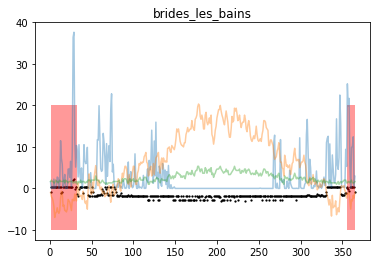

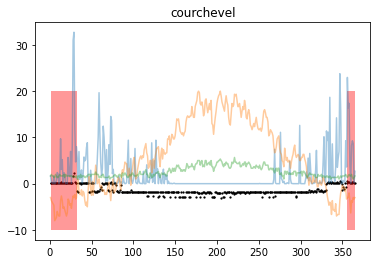

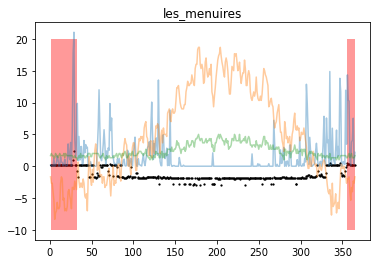

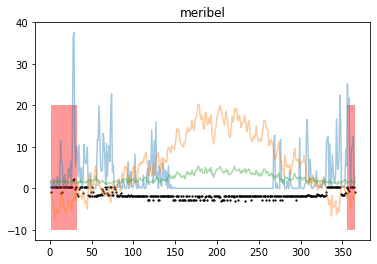

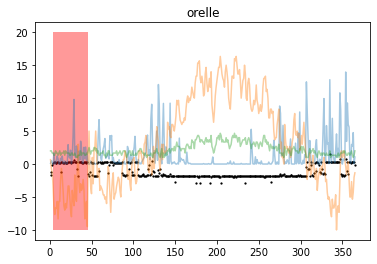

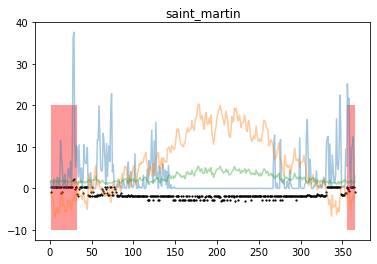

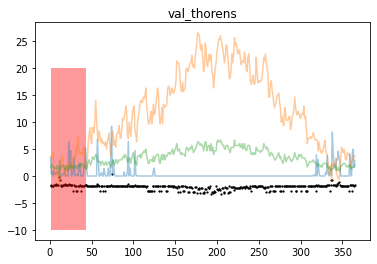

In [10]:
for vx in range(7):
    test2 = transformed_resort_data[vx]
    test3 = pd.concat([test2,test2])
    best_day_val = 0
    best_day_index = 0
    equally_good = []
    for i in range(0,365):
        #print(i)
        if test3[i:i+42].score.sum() > best_day_val:
            best_day_val = test3[i:i+42].score.sum()
            best_day_index = i
            equally_good = []
        elif best_day_val == test3[i:i+42].score.sum():
            equally_good.append(i)
    plt.scatter(test2.index,test2.score,s=1.5,color="black")
    plt.plot(test2.index,test2.totalSnow_cm_mean,alpha=0.4)
    plt.plot(test2.index,test2.avgtempC_mean,alpha=0.4)
    plt.plot(test2.index,test2.uvIndex_mean,alpha=0.4)
    if best_day_index+43 > 365:
        plt.fill_betweenx(x1=best_day_index+1,x2=365,y=[-10,20],alpha=0.4,facecolor="r")
        plt.fill_betweenx(x1=1,x2=(best_day_index+43-365),y=[-10,20],alpha=0.4,facecolor="r")
    else:
        plt.fill_betweenx(x1=best_day_index+1,x2=best_day_index+43,y=[-10,20],alpha=0.4,facecolor="r")
    plt.title(f"{resort_names[vx]}")
    plt.show()